In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential, load_model
from scipy.stats import pearsonr, spearmanr, ttest_1samp, ttest_ind_from_stats
from sklearn.metrics import auc,roc_curve,roc_auc_score, precision_recall_curve, average_precision_score, auc, balanced_accuracy_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams['svg.fonttype'] = 'none'
rcParams['font.size']=15
from classification_model import specificity_metric
import keras.metrics
keras.metrics.specifity_metric = specificity_metric

Using Theano backend.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_j42oled8.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Preallocating 7713/8119 Mb (0.950000) on cuda
Mapped name None to device cuda: GeForce GTX 1080 (0000:02:00.0)


In [2]:
classification_model_3_hg19 = load_model('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/classification_model_3.hdf5', compile=False)

In [7]:
tewhey_ref_sequences = np.load("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_one_hot_encoded_ref_sequences.npy")
tewhey_alt_sequences = np.load("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_one_hot_encoded_alt_sequences.npy")

In [8]:
ref_scores = classification_model_3_hg19.predict(tewhey_ref_sequences)
alt_scores = classification_model_3_hg19.predict(tewhey_alt_sequences)

In [9]:
tewhey_snp_info = pd.read_csv("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_snps_data_extended_joined_to_1kg_mappings_with_1kb_snp_centered_sequences_with_gm_overlaps.txt",
                              sep="\t")

In [10]:
tewhey_snp_info["Ref.score"] = ref_scores
tewhey_snp_info["Alt.score"] = alt_scores
tewhey_snp_info["Predicted.skew"] = np.log2(tewhey_snp_info["Alt.score"]) - np.log2(tewhey_snp_info["Ref.score"])

Reference Sequences: (0.14028569499310165, 1.4774026797367262e-172)
Reference Sequences: SpearmanrResult(correlation=0.16047435817765165, pvalue=7.61336528426156e-226)
Alternate Sequences: (0.13671570322749702, 6.585003944990757e-164)
Alternate Sequences: SpearmanrResult(correlation=0.15471333190605838, pvalue=7.085251131530378e-210)


/home/eramamur/bin/miniconda3/envs/gpu_keras_theano/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


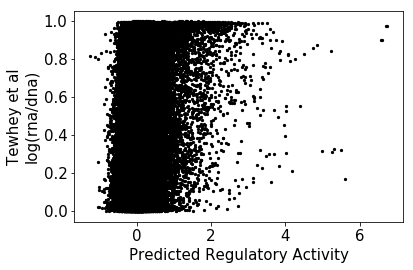

In [11]:
plt.scatter(tewhey_snp_info["C.B.log2FC"], tewhey_snp_info["Alt.score"], c='k', s=5)
plt.scatter(tewhey_snp_info["C.A.log2FC"], tewhey_snp_info["Ref.score"], c='k', s=5)
plt.ylabel("Tewhey et al\nlog(rna/dna)")
plt.xlabel("Predicted Regulatory Activity")

print("Reference Sequences:",pearsonr(np.nan_to_num(tewhey_snp_info["C.A.log2FC"]), np.log2(tewhey_snp_info["Ref.score"])))
print("Reference Sequences:",spearmanr(np.nan_to_num(tewhey_snp_info["C.A.log2FC"]), np.log2(tewhey_snp_info["Ref.score"])))
print("Alternate Sequences:",pearsonr(np.nan_to_num(tewhey_snp_info["C.B.log2FC"]), np.log2(tewhey_snp_info["Alt.score"])))
print("Alternate Sequences:",spearmanr(np.nan_to_num(tewhey_snp_info["C.B.log2FC"]), np.log2(tewhey_snp_info["Alt.score"])))

(0.029366060481354966, 5.404574019063977e-09)
SpearmanrResult(correlation=0.03679471713849458, pvalue=2.652104195305866e-13)


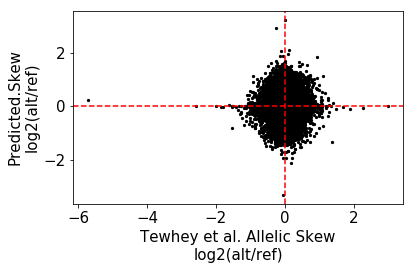

In [20]:
plt.scatter(tewhey_snp_info["LogSkew.Comb"],tewhey_snp_info["Predicted.skew"] , c = 'k', s=5)
plt.axhline(y=0, c='r', linestyle='--')
plt.axvline(x=0, c='r', linestyle='--')
plt.xlabel("Tewhey et al. Allelic Skew\nlog2(alt/ref)")
plt.ylabel("Predicted.Skew\nlog2(alt/ref)")
print(pearsonr(np.nan_to_num(tewhey_snp_info["LogSkew.Comb"]), tewhey_snp_info["Predicted.skew"]))
print(spearmanr(np.nan_to_num(tewhey_snp_info["LogSkew.Comb"]), tewhey_snp_info["Predicted.skew"]))

(0.029366060481354966, 5.404574019063977e-09)
SpearmanrResult(correlation=0.03679471713849458, pvalue=2.652104195305866e-13)


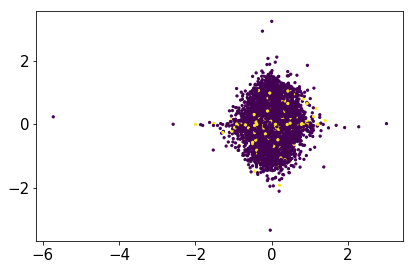

In [22]:
plt.scatter(tewhey_snp_info["LogSkew.Comb"], tewhey_snp_info["Predicted.skew"], c = tewhey_snp_info["Num.Overlaps.GM.peaks"]>0, s=5)
print(pearsonr(np.nan_to_num(tewhey_snp_info["LogSkew.Comb"]), tewhey_snp_info["Predicted.skew"]))
print(spearmanr(np.nan_to_num(tewhey_snp_info["LogSkew.Comb"]), tewhey_snp_info["Predicted.skew"]))

In [23]:
tewhey_snp_info_sig = tewhey_snp_info[tewhey_snp_info["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_sig = tewhey_snp_info_sig[np.absolute(tewhey_snp_info_sig["LogSkew.Comb"])>0.5]
print(sum(np.sign(tewhey_snp_info_sig["LogSkew.Comb"]) == np.sign(np.log2(tewhey_snp_info_sig["Alt.score"]) - np.log2(tewhey_snp_info_sig["Ref.score"]))))
print(sum(np.sign(tewhey_snp_info_sig["LogSkew.Comb"]) != np.sign(np.log2(tewhey_snp_info_sig["Alt.score"]) - np.log2(tewhey_snp_info_sig["Ref.score"]))))

239
152


(0.18423850468414066, 0.000249454374995217)
SpearmanrResult(correlation=0.19819646922314077, pvalue=7.955226220637007e-05)


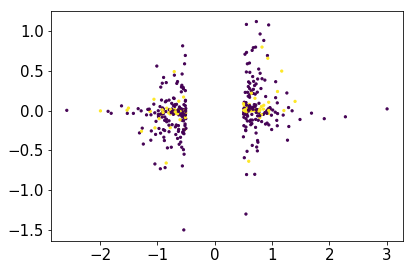

In [25]:
plt.scatter(tewhey_snp_info_sig["LogSkew.Comb"], tewhey_snp_info_sig["Predicted.skew"], c= tewhey_snp_info_sig["Num.Overlaps.GM.peaks"]>0, s=5)
print(pearsonr(np.nan_to_num(tewhey_snp_info_sig["LogSkew.Comb"]), tewhey_snp_info_sig["Predicted.skew"]))
print(spearmanr(np.nan_to_num(tewhey_snp_info_sig["LogSkew.Comb"]), tewhey_snp_info_sig["Predicted.skew"]))

In [16]:
tewhey_snp_info_pos = tewhey_snp_info[tewhey_snp_info["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_pos = tewhey_snp_info_pos[tewhey_snp_info_pos["LogSkew.Comb"]>0.5]

tewhey_snp_info_neg = tewhey_snp_info[tewhey_snp_info["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_neg = tewhey_snp_info_neg[tewhey_snp_info_neg["LogSkew.Comb"]< -0.5]


tewhey_snp_info_neutral = tewhey_snp_info[tewhey_snp_info["C.Skew.fdr"] < -np.log10(0.05)]
tewhey_snp_info_neutral = tewhey_snp_info_neutral[np.absolute(tewhey_snp_info_neutral["LogSkew.Comb"]) < 0.5]

Ttest_1sampResult(statistic=-2.868288570578354, pvalue=0.004563027632707999)
Ttest_1sampResult(statistic=-0.8457162947868478, pvalue=0.39777327088900327)
Ttest_1sampResult(statistic=2.626292752980379, pvalue=0.009351281626133138)
Ttest_indResult(statistic=-2.585112404795315, pvalue=0.010354784997373006)
Ttest_indResult(statistic=2.742374632173085, pvalue=0.0066572578826428665)


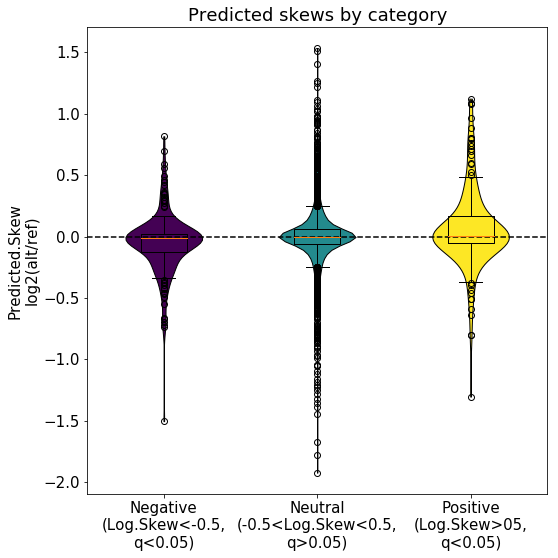

In [17]:
fig, ax = plt.subplots(figsize=(8,8))

parts = ax.violinplot(dataset=[tewhey_snp_info_neg["Predicted.skew"].tolist(), tewhey_snp_info_neutral["Predicted.skew"].tolist(), tewhey_snp_info_pos["Predicted.skew"].tolist()],showmedians=False,showextrema=False)

parts['bodies'][0].set_facecolor('#440154FF')
parts['bodies'][0].set_edgecolor('black')
parts['bodies'][0].set_alpha(1)

parts['bodies'][1].set_facecolor('#238A8DFF')
parts['bodies'][1].set_edgecolor('black')
parts['bodies'][1].set_alpha(1)    


parts['bodies'][2].set_facecolor('#FDE725FF')
parts['bodies'][2].set_edgecolor('black')
parts['bodies'][2].set_alpha(1)   

plt.boxplot([tewhey_snp_info_neg["Predicted.skew"].tolist(), tewhey_snp_info_neutral["Predicted.skew"].tolist(), tewhey_snp_info_pos["Predicted.skew"].tolist()])
plt.axhline(y=0, c='k', linestyle='--')
plt.xticks(ticks = range(1,4), labels = ["Negative\n(Log.Skew<-0.5,\nq<0.05)", "Neutral\n(-0.5<Log.Skew<0.5,\nq>0.05)", "Positive\n(Log.Skew>05,\nq<0.05)"], horizontalalignment="center")
plt.ylabel("Predicted.Skew\nlog2(alt/ref)")
plt.title("Predicted skews by category")
print(ttest_1samp(tewhey_snp_info_neg["Predicted.skew"].tolist(),0))
print(ttest_1samp(tewhey_snp_info_neutral["Predicted.skew"].tolist(),0))
print(ttest_1samp(tewhey_snp_info_pos["Predicted.skew"].tolist(),0))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_neg["Predicted.skew"]),
                     np.std(tewhey_snp_info_neg["Predicted.skew"]),
                     len(tewhey_snp_info_neg["Predicted.skew"].tolist()),
                     np.mean(tewhey_snp_info_neutral["Predicted.skew"]),
                     np.std(tewhey_snp_info_neutral["Predicted.skew"]),
                     len(tewhey_snp_info_neutral["Predicted.skew"].tolist()),
                     equal_var=False))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_pos["Predicted.skew"]),
                     np.std(tewhey_snp_info_pos["Predicted.skew"]),
                     len(tewhey_snp_info_pos["Predicted.skew"].tolist()),
                     np.mean(tewhey_snp_info_neutral["Predicted.skew"]),
                     np.std(tewhey_snp_info_neutral["Predicted.skew"]),
                     len(tewhey_snp_info_neutral["Predicted.skew"].tolist()),
                     equal_var=False))

In [18]:
tewhey_snp_info_overlapping_peaks = tewhey_snp_info[tewhey_snp_info["Num.Overlaps.GM.peaks"]>0]
tewhey_snp_info_pos = tewhey_snp_info_overlapping_peaks[tewhey_snp_info_overlapping_peaks["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_pos = tewhey_snp_info_pos[tewhey_snp_info_pos["LogSkew.Comb"]>0.5]

tewhey_snp_info_neg = tewhey_snp_info_overlapping_peaks[tewhey_snp_info_overlapping_peaks["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_neg = tewhey_snp_info_neg[tewhey_snp_info_neg["LogSkew.Comb"]< -0.5]


tewhey_snp_info_neutral = tewhey_snp_info_overlapping_peaks[tewhey_snp_info_overlapping_peaks["C.Skew.fdr"] < -np.log10(0.05)]
tewhey_snp_info_neutral = tewhey_snp_info_neutral[np.absolute(tewhey_snp_info_neutral["LogSkew.Comb"]) < 0.5]

Ttest_1sampResult(statistic=-1.2344738632919068, pvalue=0.22257604378706766)
Ttest_1sampResult(statistic=0.08422455224172103, pvalue=0.9329038705116652)
Ttest_1sampResult(statistic=1.799977288943103, pvalue=0.08002231175342324)
Ttest_indResult(statistic=-1.219304598738575, pvalue=0.22739341393544407)
Ttest_indResult(statistic=1.7890735257659112, pvalue=0.0814039685360126)


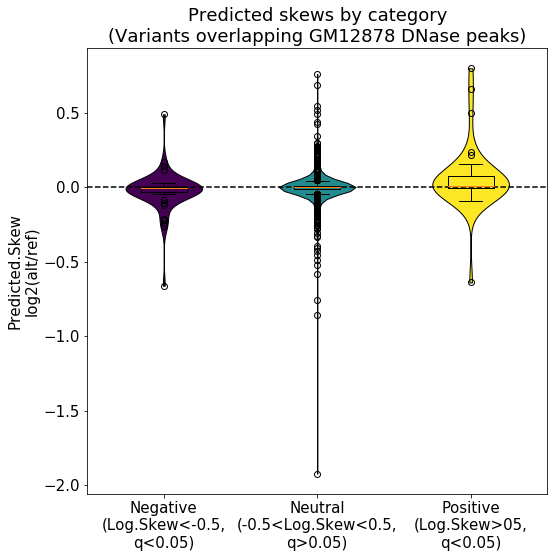

In [19]:
fig, ax = plt.subplots(figsize=(8,8))

parts = ax.violinplot(dataset=[tewhey_snp_info_neg["Predicted.skew"].tolist(), tewhey_snp_info_neutral["Predicted.skew"].tolist(), tewhey_snp_info_pos["Predicted.skew"].tolist()],showmedians=False,showextrema=False)

parts['bodies'][0].set_facecolor('#440154FF')
parts['bodies'][0].set_edgecolor('black')
parts['bodies'][0].set_alpha(1)

parts['bodies'][1].set_facecolor('#238A8DFF')
parts['bodies'][1].set_edgecolor('black')
parts['bodies'][1].set_alpha(1)    


parts['bodies'][2].set_facecolor('#FDE725FF')
parts['bodies'][2].set_edgecolor('black')
parts['bodies'][2].set_alpha(1)   

plt.boxplot([tewhey_snp_info_neg["Predicted.skew"].tolist(), tewhey_snp_info_neutral["Predicted.skew"].tolist(), tewhey_snp_info_pos["Predicted.skew"].tolist()])
plt.axhline(y=0, c='k', linestyle='--')
plt.xticks(ticks = range(1,4), labels = ["Negative\n(Log.Skew<-0.5,\nq<0.05)", "Neutral\n(-0.5<Log.Skew<0.5,\nq>0.05)", "Positive\n(Log.Skew>05,\nq<0.05)"], horizontalalignment="center")
plt.ylabel("Predicted.Skew\nlog2(alt/ref)")
plt.title("Predicted skews by category\n(Variants overlapping GM12878 DNase peaks)")
print(ttest_1samp(tewhey_snp_info_neg["Predicted.skew"].tolist(),0))
print(ttest_1samp(tewhey_snp_info_neutral["Predicted.skew"].tolist(),0))
print(ttest_1samp(tewhey_snp_info_pos["Predicted.skew"].tolist(),0))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_neg["Predicted.skew"]),
                     np.std(tewhey_snp_info_neg["Predicted.skew"]),
                     len(tewhey_snp_info_neg["Predicted.skew"].tolist()),
                     np.mean(tewhey_snp_info_neutral["Predicted.skew"]),
                     np.std(tewhey_snp_info_neutral["Predicted.skew"]),
                     len(tewhey_snp_info_neutral["Predicted.skew"].tolist()),
                     equal_var=False))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_pos["Predicted.skew"]),
                     np.std(tewhey_snp_info_pos["Predicted.skew"]),
                     len(tewhey_snp_info_pos["Predicted.skew"].tolist()),
                     np.mean(tewhey_snp_info_neutral["Predicted.skew"]),
                     np.std(tewhey_snp_info_neutral["Predicted.skew"]),
                     len(tewhey_snp_info_neutral["Predicted.skew"].tolist()),
                     equal_var=False))

In [6]:
def evaluate_model(X,Y,model):
    pred = model.predict_proba(X)
    
    fpr, tpr, thresholds = roc_curve(Y, pred, pos_label=1)
    auRoc = auc(fpr, tpr)

    precision, recall, thresholds = precision_recall_curve(Y,pred)
    auPrc = auc(recall, precision)
    averagePrecision = average_precision_score(Y, pred)
    pred_binary = pred>0.5
    balancedAccuracy = balanced_accuracy_score(Y, pred_binary)
    
    negativeClassTrue = []
    negativeClassPred = []
    positiveClassTrue = []
    positiveClassPred = []
    
    for i, val in enumerate(Y):
        currTrueLabel = Y[i]
        currPred = pred_binary[i]
        if currTrueLabel == 0:
            negativeClassTrue.append(currTrueLabel)
            negativeClassPred.append(currPred)
        else:
            positiveClassTrue.append(currTrueLabel)
            positiveClassPred.append(currPred)            

            
    negativeClassTrue = np.array(negativeClassTrue)
    negativeClassPred = np.array(negativeClassPred)
    positiveClassTrue = np.array(positiveClassTrue)
    positiveClassPred = np.array(positiveClassPred)
    
    negativeAccuracy = accuracy_score(negativeClassTrue, negativeClassPred)
    positiveAccuracy = accuracy_score(positiveClassTrue, positiveClassPred)
    
    print("auROC:",auRoc)
    print("Average precision:",averagePrecision)
    print("auPRC:",auPrc)
    print("Balanced Accuracy:",balancedAccuracy)
    print("Positive Accuracy:",positiveAccuracy)
    print("Negative Accuracy:",negativeAccuracy)
    print("Classification Report:")
    print(classification_report(Y, pred_binary))
    
    plt.figure()

    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.title("ROC (AUC: " +str(round(auRoc,2))+")")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    
    plt.figure()    
    plt.step(recall, precision, color='b', alpha=0.2,where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')
    plt.title("Precision-Recall (AUC: " +str(round(auPrc,2))+")")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()


In [3]:
X_train = np.load('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/chrs_training_summit_centered_training_set_hg19_classification_X.npy')
Y_train = np.load('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/chrs_training_summit_centered_training_set_hg19_classification_Y.npy')
X_valid = np.load('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/chr4_summit_centered_validation_set_hg19_classification_X.npy')
Y_valid = np.load('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/chr4_summit_centered_validation_set_hg19_classification_Y.npy')

auROC: 0.9638296439303305
Average precision: 0.9732517283186506
auPRC: 0.9732476995722017
Balanced Accuracy: 0.9011065724685168
Positive Accuracy: 0.9229583975346687
Negative Accuracy: 0.8792547474023648
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.88      0.89      2791
         1.0       0.91      0.92      0.92      3894

   micro avg       0.90      0.90      0.90      6685
   macro avg       0.90      0.90      0.90      6685
weighted avg       0.90      0.90      0.90      6685



/home/eramamur/bin/miniconda3/envs/gpu_keras_theano/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


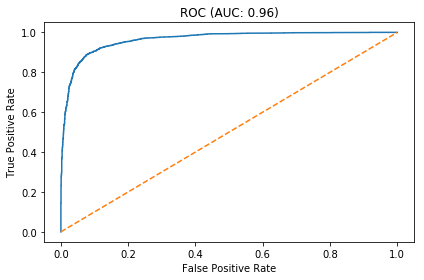

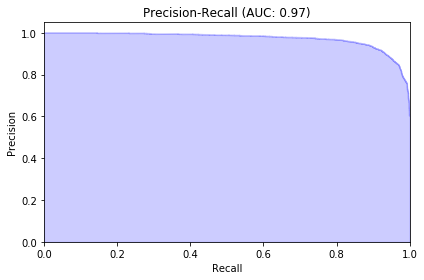

In [7]:
evaluate_model(X_valid,Y_valid,classification_model_3_hg19)

auROC: 0.9869488875506728
Average precision: 0.9917823023299903
auPRC: 0.9917823812081403
Balanced Accuracy: 0.9441905747282776
Positive Accuracy: 0.9520139745170572
Negative Accuracy: 0.9363671749394981
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93     59089
         1.0       0.96      0.95      0.96     97320

   micro avg       0.95      0.95      0.95    156409
   macro avg       0.94      0.94      0.94    156409
weighted avg       0.95      0.95      0.95    156409



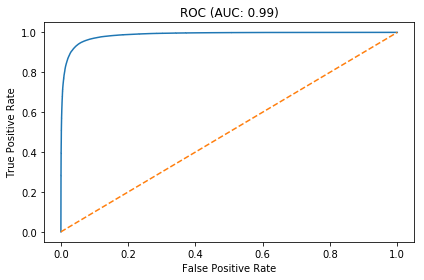

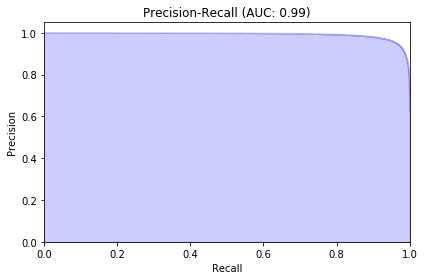

In [8]:
evaluate_model(X_train,Y_train,classification_model_3_hg19)